Cluster 1 contains vertices with indices: [33, 38, 39, 40, 50, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 70, 71, 72]
Cluster 2 contains vertices with indices: [23, 25, 26, 27, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 66, 67, 68, 69]
Cluster 3 contains vertices with indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29, 30, 31, 32, 34, 35, 36, 37, 73, 74, 75]
Distance of the route for Cluster 1: 29036.16
Optimal route for Cluster 1: [33, 39, 40, 59, 58, 57, 56, 54, 55, 50, 65, 64, 70, 71, 72, 63, 62, 61, 60, 38, 33]
Distance of the route for Cluster 2: 32106.17
Optimal route for Cluster 2: [23, 25, 26, 27, 42, 41, 53, 52, 51, 48, 49, 66, 69, 67, 68, 46, 47, 43, 44, 45, 23]
Distance of the route for Cluster 3: 52837.72
Optimal route for Cluster 3: [0, 22, 21, 20, 24, 3, 2, 4, 19, 18, 30, 29, 28, 31, 32, 34, 37, 35, 36, 17, 16, 15, 14, 73, 13, 12, 11, 10, 9, 8, 5, 6, 7, 1, 74, 75, 0]


<ipython-input-1-d8f8d65b57c3>:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes))


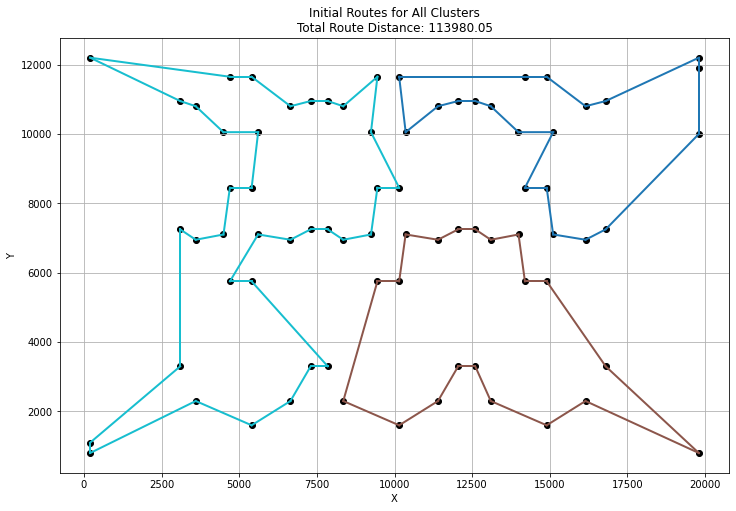

[33, 39, 40, 59, 58, 57, 56, 54, 55, 50, 51, 48, 49, 66, 69, 67, 68, 46, 47, 43, 44, 45, 23, 23, 25, 26, 27, 42, 41, 53, 52, 65, 64, 70, 71, 72, 63, 62, 61, 60, 38, 33]


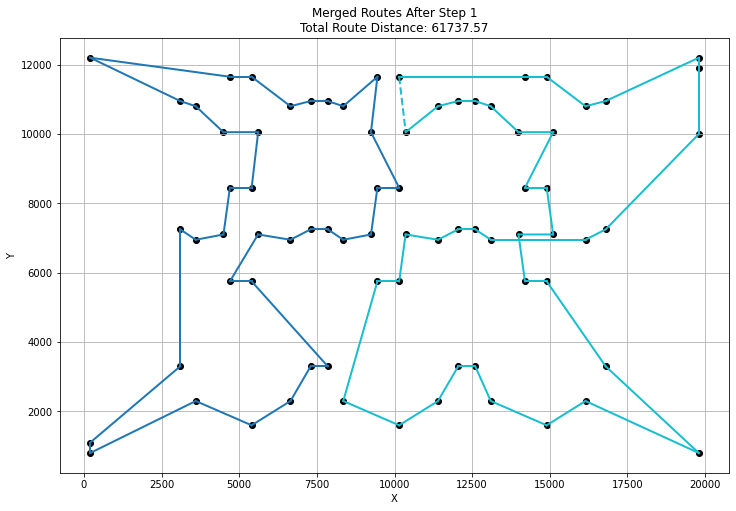

[0, 22, 21, 20, 24, 3, 2, 4, 19, 18, 30, 29, 28, 31, 32, 34, 37, 38, 33, 39, 40, 59, 58, 57, 56, 54, 55, 50, 51, 48, 49, 66, 69, 67, 68, 46, 47, 43, 44, 45, 23, 25, 26, 27, 42, 41, 53, 52, 65, 64, 70, 71, 72, 63, 62, 61, 60, 35, 36, 17, 16, 15, 14, 73, 13, 12, 11, 10, 9, 8, 5, 6, 7, 1, 74, 75, 0]


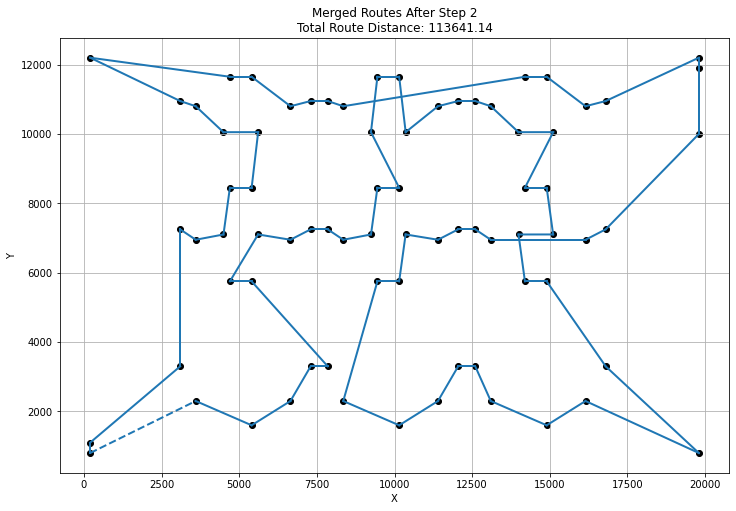

Final merged route: [0, 22, 21, 20, 24, 3, 2, 4, 19, 18, 30, 29, 28, 31, 32, 34, 37, 38, 33, 39, 40, 59, 58, 57, 56, 54, 55, 50, 51, 48, 49, 66, 69, 67, 68, 46, 47, 43, 44, 45, 23, 25, 26, 27, 42, 41, 53, 52, 65, 64, 70, 71, 72, 63, 62, 61, 60, 35, 36, 17, 16, 15, 14, 73, 13, 12, 11, 10, 9, 8, 5, 6, 7, 1, 74, 75]
76


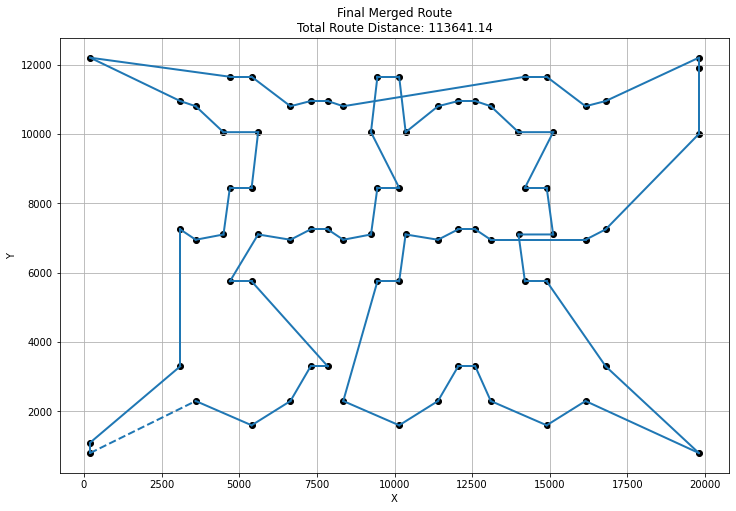

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def k_means(X, k, max_iterations=100, tol=1e-4):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for iteration in range(max_iterations):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels

def read_tsp_file(file_path):
    tsp_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = []
    for line in lines:
        if line.startswith("NODE_COORD_SECTION"):
            for i in range(lines.index(line) + 1, len(lines)):
                if lines[i].strip() == "EOF":
                    break
                parts = lines[i].split()
                x = float(parts[1])
                y = float(parts[2])
                coordinates.append((x, y))
            tsp_data['coordinates'] = coordinates

    return tsp_data

def create_data_model(cluster_points):
    data = {}
    data['distance_matrix'] = create_distance_matrix(cluster_points)
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def create_distance_matrix(points):
    size = len(points)
    distance_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i != j:
                distance_matrix[i][j] = np.linalg.norm(points[i] - points[j])
    return distance_matrix

def solve_tsp(data, time_limit=1):
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = time_limit
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        return get_solution(manager, routing, solution)
    else:
        return None

def get_solution(manager, routing, solution):
    index = routing.Start(0)
    route = []
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))
    return route

def calculate_route_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i+1]]
    return total_distance

def merge_routes(route1, route2, coordinates):
    min_distance = float('inf')
    best_i, best_j = -1, -1

    for i in range(len(route1)):
        for j in range(len(route2)):
            dist = np.linalg.norm(coordinates[route1[i]] - coordinates[route2[j]])
            if dist < min_distance:
                min_distance = dist
                best_i, best_j = i, j

    new_route = route1[:best_i+1] + route2[best_j:] + route2[:best_j] + route1[best_i+1:]
    print(new_route)
    new_route = list(dict.fromkeys(new_route)) 
    return new_route

def plot_all_routes(coordinates, routes, total_distance, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='black', zorder=1)
    
    colors = plt.cm.get_cmap('tab10', len(routes))
    for i, route in enumerate(routes):
        color = colors(i)
        for j in range(len(route) - 1):
            start, end = route[j], route[j+1]
            plt.plot([coordinates[start][0], coordinates[end][0]], 
                     [coordinates[start][1], coordinates[end][1]], 
                     color=color, linewidth=2, zorder=2)
        plt.plot([coordinates[route[-1]][0], coordinates[route[0]][0]], 
                 [coordinates[route[-1]][1], coordinates[route[0]][1]], 
                 color=color, linewidth=2, zorder=2, linestyle='--')

    plt.title(f"{title}\nTotal Route Distance: {total_distance:.2f}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()


file_path = 'pr76.tsp'
tsp_data = read_tsp_file(file_path)
coordinates = np.array(tsp_data['coordinates'])

indexed_coordinates = {i: coord for i, coord in enumerate(coordinates)}

num_clusters = 3

centroids, labels = k_means(coordinates, num_clusters)

for i in range(num_clusters):
    cluster_indices = [index for index, label in enumerate(labels) if label == i]
    print(f'Cluster {i + 1} contains vertices with indices: {cluster_indices}')

cluster_routes = []
total_distance = 0

for i in range(num_clusters):
    cluster_points = coordinates[labels == i]

    data = create_data_model(cluster_points)
    optimal_route = solve_tsp(data)

    if optimal_route:
        cluster_routes.append([np.where((coordinates == cluster_points[label]).all(axis=1))[0][0] for label in optimal_route])

        route_distance = calculate_route_distance(optimal_route, data['distance_matrix'])
        total_distance += route_distance
        print(f'Distance of the route for Cluster {i + 1}: {route_distance:.2f}')
        
        cluster_indices = [index for index, label in enumerate(labels) if label == i]
        cluster_route = [cluster_indices[node] for node in optimal_route]
        print(f'Optimal route for Cluster {i + 1}: {cluster_route}')
    else:
        cluster_routes.append([])

plot_all_routes(coordinates, cluster_routes, total_distance, 'Initial Routes for All Clusters')

merge_step = 1
while len(cluster_routes) > 1:
    route1 = cluster_routes.pop(0)
    route2 = cluster_routes.pop(0)
    merged_route = merge_routes(route1, route2, coordinates)
    cluster_routes.append(merged_route)
    
    distance_matrix = create_distance_matrix(coordinates)
    total_distance = calculate_route_distance(merged_route, distance_matrix)
    
    plot_all_routes(coordinates, cluster_routes, total_distance, f'Merged Routes After Step {merge_step}')
    merge_step += 1

final_route = cluster_routes[0]

print(f'Final merged route: {final_route}')
print(len(final_route))
plot_all_routes(coordinates, [final_route], total_distance, 'Final Merged Route')

